# MAJ : 
1. Ajout de la foncton err_fac (dans la section Decomposition - ALS), test avec des cp_tensor, err=1.2
2. Ajout des fonctions her_Als et CPRAND (dans la section Decomposition)
3. Section Comparaison of algorithms
4. her_CPRAND : modifier la position où on normalise les factors, sinon erreurs oscillent.
5. Section Decomposition - her-CPRAND - param_research

Questions : 
1. CPRAND data fitting error ne fait que diminuer ? 
2. her-Als marche moins bien?


In [1]:
pip install -U tensorly

  Created wheel for tensorly: filename=tensorly-0.5.0-cp37-none-any.whl size=143031 sha256=e9c73eac8312aea0103c98e4dce8e2c5e3ff616a0c4cb371054e3c86b1911ea3
  Stored in directory: C:\Users\sunkefan1997\AppData\Local\pip\Cache\wheels\29\54\bc\46d12f7739ad709844b21801e3a91127bc91002111448e3572
Successfully built tensorly
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

In [3]:
import tensorly as tl

In [4]:
import matplotlib.pyplot as plt

In [5]:
from tensorly.decomposition import parafac

In [6]:
from tensorly.decomposition import sample_khatri_rao

In [7]:
from scipy.optimize import linear_sum_assignment

# Basic operations

### Creation of tensors

In [13]:
# create a random 3x3x3 tensor
t_rand = np.random.random((3, 3, 3))

In [17]:
# create a kruskal tensor
# factor matrices
A=np.arange(9).reshape(3,3)
B=np.arange(6).reshape(2,3)+9
C=np.arange(6).reshape(2,3)+15
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
t_krus = tl.cp_to_tensor((None,factors))
weights_cp,factors_cp=tl.cp_normalize((None,factors))

In [18]:
t_krus

array([[[ 534,  630],
        [ 684,  807]],

       [[1980, 2346],
        [2562, 3036]],

       [[3426, 4062],
        [4440, 5265]]])

# Decomposition

### ALS

In [10]:
# stopping criteria 
def err(tensor,weight,factors): 
  t_tilde=tl.kruskal_to_tensor((weight,factors)) # transform tensor decomposition (kruskal tensor) to tensor
  return(tl.norm(tensor-t_tilde))

In [11]:
def err_fac(fac,fac_est) :
  weights,fac=tl.cp_normalize((None,fac))
  weights_est,fac_est=tl.cp_normalize((None,fac_est))
  err=0
  for i in range(len(fac)):
    row_ind, col_ind = linear_sum_assignment(-np.dot(np.transpose(fac[i]),fac_est[i]))
    err=err+(tl.norm(fac[i]-fac_est[i][:,col_ind])/tl.norm(fac[i]))
  return(err/len(fac))

In [12]:
# ALS method to compute tensor decomposition
def als(tensor,rank,it_max=100,tol=1e-5,list_factors=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[] # factor matrices
  if list_factors==True : list_fac=[] # list of factor matrices
  # Initializtion of factor matrices by left singular vectors
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) # first rank eigenvectors/values (ascendent)
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  # sometimes we have singular matrix error
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors)) # normalise factor matrices
  if list_factors==True : list_fac.append(factors)
  it=0
  error=[err(tensor,weights,factors)/norm_tensor]
  while (error[len(error)-1]>tol and it<it_max): 
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors[i]),factors[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors), n) # do I need to reverse factors ? --> no deja bon ordre (même matricization que dans le chapitre)
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
    weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    if list_factors==True : list_fac.append(factors)
    it=it+1
    error.append(err(tensor,weights,factors)/norm_tensor)
  if list_factors==True : return(weights,factors,it,error,list_fac)
  return(weights,factors,it,error)

#### Test

In [ ]:
# test err
tensor=tl.tensor(np.arange(12,dtype='d').reshape((3, 2, 2)))
err(tensor,None,factors) # with factors of t_krus

19.52482738830653

##### Test als random tensor

In [105]:
# test als with a random tensor, rank = 3 (order)
weights,factors,it,error=als(t_rand,3)
tl.kruskal_to_tensor((weights,factors))

array([[[0.19322252, 0.77354543, 0.56612688],
        [0.53655902, 0.75110155, 0.53331251],
        [0.34254872, 0.94794514, 0.30782572]],

       [[0.88927612, 0.32086305, 0.88934069],
        [0.99006478, 0.69371326, 0.31465987],
        [0.02076603, 0.99288277, 0.69069182]],

       [[0.3375135 , 0.41164169, 0.77131647],
        [0.6904317 , 0.1009562 , 0.46599602],
        [0.08411324, 0.98959391, 0.42269264]]])

In [ ]:
# compare with parafac in tensorly
kt=parafac(t_rand,3)
tl.kruskal_to_tensor(kt)

array([[[-0.03241677,  0.61279207,  0.70886661],
        [ 0.46115924,  0.53563678,  0.86173867],
        [ 0.90194071,  0.72276686,  0.60356948]],

       [[ 0.996882  ,  0.90382069,  0.30767755],
        [ 0.37957336,  0.28732192,  0.92421589],
        [ 0.10219771,  0.23627233,  0.63526964]],

       [[ 0.84400725,  0.87810977,  0.88670026],
        [ 0.65039937,  0.90023297,  0.09543731],
        [ 0.47748812,  0.68628132,  0.28001158]]])

In [ ]:
# compare with the initial tensor
t_rand

array([[[0.01594988, 0.53863851, 0.74314515],
        [0.35051446, 0.68047374, 0.91021337],
        [0.98084704, 0.57280514, 0.58977904]],

       [[0.97079119, 0.98316417, 0.31039431],
        [0.30055351, 0.34178026, 0.99367175],
        [0.09711228, 0.21961374, 0.49048895]],

       [[0.95799804, 0.76798269, 0.86040398],
        [0.54264035, 0.84422842, 0.1197907 ],
        [0.50225161, 0.89019987, 0.2449824 ]]])

In [ ]:
# test als with a random tensor, rank = 100
weights,factors,it,error=als(t_rand,100)
tl.kruskal_to_tensor((weights,factors))

array([[[0.01594988, 0.53863851, 0.74314515],
        [0.35051446, 0.68047374, 0.91021337],
        [0.98084704, 0.57280514, 0.58977904]],

       [[0.97079119, 0.98316417, 0.31039431],
        [0.30055351, 0.34178026, 0.99367175],
        [0.09711228, 0.21961374, 0.49048895]],

       [[0.95799804, 0.76798269, 0.86040398],
        [0.54264035, 0.84422842, 0.1197907 ],
        [0.50225161, 0.89019987, 0.2449824 ]]])

##### Test als cp tensor

In [19]:
# test als with the Kurskal tensor in section Basic operations
weights,factors,it,error,l=als(t_krus,3,list_factors=True)
it

2

In [20]:
tl.kruskal_to_tensor((weights,factors))

array([[[ 533.98796457,  630.0095696 ],
        [ 684.00032554,  806.99974116]],

       [[1980.01846365, 2345.9853192 ],
        [2561.98281253, 3036.01366609]],

       [[3426.04896272, 4061.9610688 ],
        [4439.96529952, 5265.02759102]]])

In [21]:
# compare with the initial tensor
t_krus

array([[[ 534,  630],
        [ 684,  807]],

       [[1980, 2346],
        [2562, 3036]],

       [[3426, 4062],
        [4440, 5265]]])

We obtain the same tensor, but not the same decomposition (weights and factors are different from the definition of t_krus), because of permutation and normalization.

In [23]:
# Test err_fac
err_fac(factors_cp,factors)

1.2842831034770532

In [24]:
# with another random cp_tensor
A=np.random.random((3, 3))
B=np.random.random((2, 3))
C=np.random.random((2, 3))
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
t_krus = tl.cp_to_tensor((None,factors))
weights_cp,factors_cp=tl.cp_normalize((None,factors))

In [25]:
weights,factors,it,error=als(t_krus,3)
it

100

In [26]:
tl.cp_to_tensor((weights,factors))

array([[[0.15845546, 0.08403661],
        [0.17507059, 0.08110877]],

       [[0.64335869, 0.56282454],
        [0.58149447, 0.36367407]],

       [[0.71280857, 0.69947044],
        [0.60289581, 0.41362682]]])

In [27]:
t_krus

array([[[0.15430277, 0.08429191],
        [0.17667439, 0.08547434]],

       [[0.64777902, 0.56255779],
        [0.57976776, 0.35901495]],

       [[0.70977863, 0.69968252],
        [0.60405227, 0.41681967]]])

In [28]:
err_fac(factors_cp,factors)

1.3452574514439812

In [30]:
cp_para=parafac(t_krus,3)

In [31]:
err_fac(factors_cp,cp_para.factors)

1.347404614044416

In [32]:
tl.cp_to_tensor(cp_para)

array([[[0.15832974, 0.08410778],
        [0.17519403, 0.08100264]],

       [[0.64346429, 0.56272616],
        [0.58138243, 0.36380836]],

       [[0.71272519, 0.69952768],
        [0.60298974, 0.41354895]]])

### her_Als

In [29]:
def her_Als(tensor,rank,it_max=100,err_it_max=20,tol=1e-5,beta=0.5,eta=1.5,gamma=1.05,gamma_bar=1.01,list_factors=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u] 
  # Initialization of factor hat matrices by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(factors)

  it=0
  err_it=0
  cpt=0
  error=[err(tensor,None,factors)/norm_tensor]
  min_err=error[len(error)-1]
  F_hat_bf=err(tensor,None,factors) # cost

  while (min_err>tol and it<it_max and err_it<err_it_max): 
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors_hat[i]),factors_hat[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors_hat), n) 
      factor_bf=factors[n]
      # update
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    F_hat_new = err(tensor,None,factors_hat) # cost update 
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(factors)
    error.append(err(tensor,None,factors)/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
  weights,factors=tl.cp_normalize((None,factors))
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  return(weights,factors,it,error,cpt/it)


#### Test

In [29]:
weights,factors,it,error,cpt=her_Als(t_krus,3)
it

8

In [30]:
cpt

0.0

In [31]:
tl.kruskal_to_tensor((weights,factors))

array([[[ 534.00354641,  630.00069902],
        [ 683.99479348,  806.99730079]],

       [[1979.97442269, 2346.00143971],
        [2561.98532488, 3035.99045913]],

       [[3425.98683655, 4061.99912303],
        [4439.97354272, 5264.98378775]]])

### CPRAND

In [33]:
def CPRAND(tensor,rank,n_samples,exact_err=True,it_max=100,err_it_max=20,tol=1e-6,list_factors=False):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors))
  if list_factors==True : list_fac.append(factors) 

  it=0
  err_it=0
  if(exact_err==False):
    error=[err_rand(tensor,weights,factors,int(10*rank*np.log(rank)+1))/norm_tensor] 
  else :
    error=[err(tensor,weights,factors)/norm_tensor]
  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tl.transpose(tensor[indices_list]) # because of the matricization
      else : sampled_unfolding =tensor[indices_list]
      # update
      factors[n] = tl.transpose(tl.solve(tl.dot(tl.transpose(Zs),Zs),tl.dot(tl.transpose(Zs),sampled_unfolding))) # solve needs a squared matrix
    
    weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    if list_factors==True : list_fac.append(factors)
    it=it+1
    if(exact_err==False):
      error.append(err_rand(tensor,weights,factors,int(10*rank*np.log(rank)+1))/norm_tensor)
    else : error.append(err(tensor,weights,factors)/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
  if list_factors==True : return(weights,factors,it,error,list_fac)
  return(weights,factors,it,error)

#### Test

In [52]:
rank=3
n_samples=int(10*rank*np.log(rank)+1)
weights,factors,it,error=CPRAND(t_krus,rank,n_samples)
it

3

In [53]:
tl.cp_to_tensor((weights,factors))

array([[[ 533.99987534,  630.00008567],
        [ 683.99992503,  807.00005152]],

       [[1980.00036531, 2345.99974896],
        [2561.99984183, 3036.0001087 ]],

       [[3426.00085527, 4061.99941225],
        [4439.99975862, 5265.00016588]]])

### her-CPRAND



**Questions**

1.   algo comparaison : condition number to 100, log scale ? P4






#### Stopping criteria

In [34]:
# Stopping criteria of CPRAND
def err_rand(tensor,weights,factors,nb_samples): # P should be little than the total number of indices, otherwise no sense.
  indices_list = [np.random.randint(0, tl.shape(m)[0], size=nb_samples, dtype=int) for m in factors] 
  indices_list = [i.tolist() for i in indices_list]
  indices_list = tuple(indices_list)
  est_values=[]
  P=1
  for i in tl.shape(t_krus) : P=P*i
  for i in range(nb_samples):
     value=weights
     for mode in range(tl.ndim(tensor)) :
       value=value*factors[mode][indices_list[mode][i],:]
     est_values+=[sum(value)]
  return(np.sqrt(sum((tensor[indices_list]-est_values)**2)*P/nb_samples)) 

##### Test for err

In [ ]:
indices_list=[np.random.randint(0, tl.shape(m)[0], size=4, dtype=int) for m in factors]

In [ ]:
indices_list = [i.tolist() for i in indices_list]
indices_list = tuple(indices_list) 
indices_list

([2, 0, 1, 2], [1, 0, 1, 1], [0, 1, 1, 1])

In [ ]:
t_krus[indices_list] 

array([4440.,  630., 3036., 5265.])

In [ ]:
est_values=[]
for i in range(4) : # P 
  value=weights
  for mode in range(tl.ndim(t_krus)) : 
     value=value*factors[mode][indices_list[mode][i],:]
  est_values+=[sum(value)]

In [ ]:
est_values

[4440.0, 630.0, 3036.0, 5265.0]

In [ ]:
err_rand(t_krus,weights,factors,4)

9.646648066153113e-13

#### Main method

In [35]:
# exact_err indicates whether we use exact error calculation or randomised error calculation
# list_factors indicates whether we return the list of factors generated at each iteration
# we stop the algorithm if min_err is not updated for err_it_max iterations

def her_CPRAND(tensor,rank,n_samples,exact_err=True,it_max=100,err_it_max=20,tol=1e-6,beta=0.1,eta=2,gamma=1.01,gamma_bar=1.005,list_factors=False):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]
  if list_factors==True : list_fac=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  # Initialization of factor hat matrice by factor matrices
  factors_hat=factors
  if list_factors==True : list_fac.append(factors)
  F_hat_bf=err(tensor,None,factors) # exact cost

  it=0
  err_it=0
  cpt=0
  if(exact_err==False):
    error=[err_rand(tensor,None,factors,int(10*rank*np.log(rank)+1))/norm_tensor] 
  else :
    error=[err(tensor,None,factors)/norm_tensor]
  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors_hat,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tl.transpose(tensor[indices_list]) # because of the matricization
      else : sampled_unfolding =tensor[indices_list]
      factor_bf=factors[n]
      # update
      factors[n] = tl.transpose(tl.solve(tl.dot(tl.transpose(Zs),Zs),tl.dot(tl.transpose(Zs),sampled_unfolding))) # solve needs a squared matrix, if rank>nb_sampls ok
      # if (n==N-1) : F_hat_new=tl.norm(tl.dot(Zs,tl.transpose(factors[n]))-sampled_unfolding,2) # cost update 
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    F_hat_new = err(tensor,None,factors_hat) # exact cost update 
    if (F_hat_new>F_hat_bf):
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
      cpt=cpt+1
    else :
      factors=factors_hat
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    F_hat_bf=F_hat_new
    it=it+1
    if list_factors==True : list_fac.append(factors)
    if(exact_err==False):
      error.append(err_rand(tensor,None,factors,int(10*rank*np.log(rank)+1))/norm_tensor)
    else : error.append(err(tensor,None,factors)/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
  weights,factors=tl.cp_normalize((None,factors))
  if list_factors==True : return(weights,factors,it,error,cpt/it,list_fac)
  return(weights,factors,it,error,cpt/it)

##### Test 

###### Test sample_kahtri_rao

In [ ]:
# test sample_kahtri_rao
Zs,indices=tl.decomposition.sample_khatri_rao(factors,2,skip_matrix=1)

/usr/local/lib/python3.6/dist-packages/tensorly/decomposition/_cp.py:604: UserWarning: You are creating a new random number generator at each call.
If you are calling sample_khatri_rao inside a loop this will be slow: best to create a rng outside and pass it as argument (random_state=rng).
  warnings.warn('You are creating a new random number generator at each call.\n'


In [ ]:
t_krus[...,0]

array([[ 534.,  684.],
       [1980., 2562.],
       [3426., 4440.]])

In [ ]:
t_krus[...,1]

array([[ 630.,  807.],
       [2346., 3036.],
       [4062., 5265.]])

In [ ]:
factors

[array([[0.        , 0.12309149, 0.20739034],
        [0.4472136 , 0.49236596, 0.51847585],
        [0.89442719, 0.86164044, 0.82956136]]),
 array([[0.6       , 0.60971076, 0.61782155],
        [0.8       , 0.79262399, 0.78631834]]),
 array([[0.6401844 , 0.64413575, 0.64764842],
        [0.76822128, 0.7649112 , 0.76193932]])]

In [ ]:
tl.tenalg.khatri_rao(factors,skip_matrix=1)

array([[-7.49125408e-07,  2.62419513e+02,  6.05352789e+02],
       [-8.98950490e-07,  3.11623172e+02,  7.12179752e+02],
       [ 6.74999997e+02,  1.04967805e+03,  1.51338197e+03],
       [ 8.09999996e+02,  1.24649269e+03,  1.78044938e+03],
       [ 1.35000003e+03,  1.83693651e+03,  2.42141120e+03],
       [ 1.62000004e+03,  2.18136210e+03,  2.84871906e+03]])

In [ ]:
Zs # line 5 and 3

array([[1350.00003412, 1836.93650543, 2421.41119956],
       [ 674.99999656, 1049.67805344, 1513.38197013]])

In [ ]:
indices

[array([1, 1]), array([0, 1])]

In [ ]:
indices_list = [i.tolist() for i in indices]

In [ ]:
indices_list.insert(1, slice(None, None, None))

In [ ]:
indices_list

[[1, 1], slice(None, None, None), [0, 1]]

In [ ]:
indices_list = tuple(indices_list)

In [ ]:
sampled_unfolding = t_krus[indices_list]

In [ ]:
sampled_unfolding

array([[3426., 4440.],
       [1980., 2562.]])

In [ ]:
sampled_unfolding = tl.transpose(t_krus[indices_list])

In [ ]:
tl.solve(tl.dot(tl.transpose(Zs),Zs),tl.dot(tl.transpose(Zs),sampled_unfolding))

array([[ 1023.30028924, -1093.43495461,  6201.96856949],
       [-1727.69563215,  6110.96759931, -5688.58900876],
       [ 2048.        ,    -0.        ,  8192.        ]])

###### Test her_CPRAND

In [90]:
# with a cp_tensor (order=3)
rank=3
n_samples=int(10*rank*np.log(rank)+1) # pour qu'il soit bien conditionne ?
weights,factors,it,error,cpt=her_CPRAND(t_krus,rank,n_samples,True) 
it 

3

In [47]:
cpt

0.42857142857142855

In [48]:
min(error) 

2.8690861694026314e-07

In [49]:
tl.cp_to_tensor((weights,factors))

array([[[ 534.00015325,  630.00018085],
        [ 684.00019639,  807.00023177]],

       [[1980.00056814, 2346.00067308],
        [2562.00073518, 3036.00087107]],

       [[3426.00098304, 4062.0011653 ],
        [4440.00127397, 5265.00151037]]])

In [ ]:
t_krus

array([[[ 534.,  630.],
        [ 684.,  807.]],

       [[1980., 2346.],
        [2562., 3036.]],

       [[3426., 4062.],
        [4440., 5265.]]])

In [91]:
# with a random tensor, order = 4
t_rand = np.random.random((3, 2, 2, 4))
t_rand

array([[[[3.45210759e-01, 2.61596152e-01, 2.02732113e-01,
          3.74311288e-01],
         [3.45011496e-01, 8.81756739e-01, 5.57438393e-01,
          2.26718380e-01]],

        [[3.26505074e-02, 8.18877912e-01, 6.40468645e-01,
          3.84369049e-01],
         [3.09283982e-01, 8.20579969e-01, 3.25873459e-01,
          9.02817501e-01]]],


       [[[6.17028145e-01, 4.12258733e-01, 6.68918877e-01,
          9.71290556e-01],
         [3.88504817e-01, 1.81419185e-01, 6.37851147e-01,
          1.45103768e-01]],

        [[8.83005220e-01, 5.26873996e-01, 6.95104481e-01,
          4.29103381e-03],
         [4.04611802e-01, 1.26643570e-01, 8.01667481e-04,
          8.56884366e-01]]],


       [[[3.06671107e-01, 4.66366553e-01, 7.17476186e-01,
          9.57018854e-01],
         [5.08130723e-01, 5.80589850e-02, 7.42943764e-01,
          4.31217220e-02]],

        [[2.10543341e-01, 3.59773026e-01, 8.35373039e-01,
          4.54509356e-01],
         [1.86585209e-01, 3.96049783e-01, 1.3596737

In [92]:
# here rank=3
weights,factors,it,error,cpt=her_CPRAND(t_rand,rank,n_samples) 
it

27

In [36]:
cpt

0.4230769230769231

In [35]:
min(error)

0.10042122757586461

In [34]:
tl.cp_to_tensor((weights,factors))

array([[[[ 0.17663223,  0.73732903,  0.45129973,  0.24985936],
         [ 0.5513445 ,  0.30263394,  0.37326805,  0.24943342]],

        [[-0.00638867,  0.4985665 ,  0.64057291,  0.68726756],
         [ 0.32241669,  0.32540104,  0.33481099,  0.36900561]]],


       [[[ 0.44487457,  0.98881828,  0.53529214,  0.73784062],
         [ 0.77198149,  0.62789082,  0.78260085,  0.3918231 ]],

        [[ 0.71793431,  0.5252496 ,  1.0049337 ,  0.48921553],
         [ 0.85272498,  0.32037572,  0.33127989,  0.60122195]]],


       [[[ 0.27530702,  0.75004829,  0.84780706, -0.01988332],
         [ 0.75989413,  0.13328706,  0.12852173,  0.39556226]],

        [[ 0.19429971,  0.31954152,  0.12436782,  0.97401127],
         [ 0.1549736 ,  0.527309  ,  0.63901836,  0.21807301]]]])

In [38]:
# here rank = 100
rank=100
n_samples=int(10*rank*np.log(rank)+1)
weights,factors,it,error,cpt=her_CPRAND(t_rand,rank,n_samples) 
it

9

In [39]:
cpt

0.5555555555555556

In [96]:
tl.cp_to_tensor((weights,factors))

array([[[[3.45210759e-01, 2.61752792e-01, 2.02732113e-01,
          3.73842529e-01],
         [3.45011496e-01, 8.81699508e-01, 5.57438393e-01,
          2.27029632e-01]],

        [[3.26505074e-02, 8.18877912e-01, 6.40468645e-01,
          3.84369049e-01],
         [3.09283982e-01, 8.20579969e-01, 3.25873460e-01,
          9.02817501e-01]]],


       [[[6.17028145e-01, 4.12064230e-01, 6.68918877e-01,
          9.71290556e-01],
         [3.88504817e-01, 1.81469760e-01, 6.37851147e-01,
          1.45103768e-01]],

        [[8.83005220e-01, 5.26873996e-01, 6.95104481e-01,
          4.29103381e-03],
         [4.04611802e-01, 1.26643570e-01, 8.01667481e-04,
          8.56884366e-01]]],


       [[[3.06671107e-01, 4.66302246e-01, 7.17476187e-01,
          9.57018854e-01],
         [5.08130723e-01, 5.81296213e-02, 7.42943764e-01,
          4.31217220e-02]],

        [[2.10596398e-01, 3.60004571e-01, 8.35373039e-01,
          4.54509356e-01],
         [1.86578110e-01, 3.95983741e-01, 1.3596737

In [95]:
# here rank=100, n_samples=40
weights,factors,it,error,cpt=her_CPRAND(t_rand,100,40) 

#### Research of optimal parameters

cf P12, 14-15, long article of her.  
y-axis : data fitting error $f-f_{min}$ with exact error calculation (or factors error)  
x-axis : nb iteration

In [36]:
I=50
J=50
K=50
r=10 # rank
n_samples=int(10*r*np.log(r)+1) # nb of randomized samples
nb_rand=10 # nb of random initialization

In [37]:
def param_research(I,J,K,r,nb_rand,n_samples,exact_err=True,beta=True,eta=False,gamma=False):
  list_err1=[]
  list_err2=[]
  list_err3=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    A=np.random.normal(0, 1, size=(I, r))
    B=np.random.normal(0, 1, size=(J, r))
    C=np.random.normal(0, 1, size=(K, r))
    noise=np.random.normal(0, 0.001, size=(I,J,K))
    tensor=tl.cp_to_tensor((None,[A,B,C]))+noise
    norm_tensor=tl.norm(tensor,2)
    if(min_e==None) : min_e=norm_tensor
    # parameter choice
    if(beta==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.1) # beta0=0.1
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.3) # beta0=0.3
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.5) # beta0=0.5
    if(eta==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=1.1) # eta=1.1
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=2) # eta=2
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=3) # eta=3
    if(gamma==True):
      weights1,factors1,it1,error1,cpt1=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.01,gamma_bar=1.005) 
      weights2,factors2,it2,error2,cpt2=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.05,gamma_bar=1.01) 
      weights3,factors3,it3,error3,cpt3=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.9,gamma_bar=1.5) 
    error1=[i * norm_tensor for i in error1]
    list_err1.append(error1)
    error2=[i * norm_tensor for i in error2]
    list_err2.append(error2)
    error3=[i * norm_tensor for i in error3]
    list_err3.append(error3)
    if (min_e>min(min(error1),min(error2),min(error3))) : min_e=min(min(error1),min(error2),min(error3))
  list_err1=[x-min_e for x in list_err1]
  list_err2=[x-min_e for x in list_err2]
  list_err3=[x-min_e for x in list_err3]
  # plot
  for i in range(len(list_err1)):
    plt.plot(range(len(list_err1[i])),list_err1[i],'b-') 
  for i in range(len(list_err2)):
    plt.plot(range(len(list_err2[i])),list_err2[i],'r-') 
  for i in range(len(list_err3)):
    plt.plot(range(len(list_err3[i])),list_err3[i],'g-')
  plt.yscale("log") 

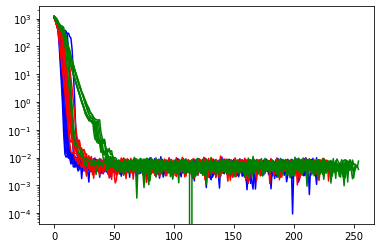

In [38]:
# with exact_error
param_research(I,J,K,r,nb_rand,n_samples,beta=True,exact_err=True)

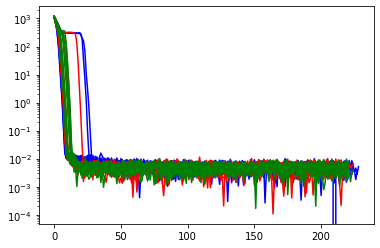

In [39]:
param_research(I,J,K,r,nb_rand,n_samples,beta=False,eta=True)

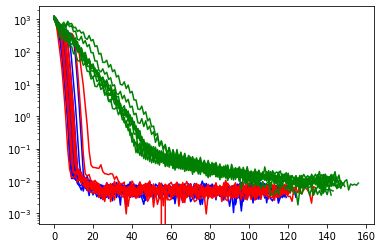

In [40]:
param_research(I,J,K,r,nb_rand,n_samples,beta=False,gamma=True)

### Comparaison of algorithms

#### her_Als and als for 1 tensor

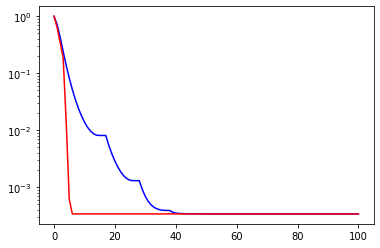

In [41]:
# initialization of a random tensor with noise
A=np.random.normal(0, 1, size=(I*2, r))
B=np.random.normal(0, 1, size=(J*2, r))
C=np.random.normal(0, 1, size=(K*2, r))
noise=np.random.normal(0, 0.001, size=(I*2,J*2,K*2))
tensor=tl.cp_to_tensor((None,[A,B,C]))+noise

# her als
weights1,factors1,it1,error1,cpt=her_Als(tensor,r,it_max=100,err_it_max=20) 
# als
weights2,factors2,it2,error2=als(tensor,r,it_max=100)

# plot
plt.plot(range(len(error1)),error1,'b-')
plt.plot(range(len(error2)),error2,'r-') 
plt.yscale("log") 

In [42]:
print("it her als:",it1,"it als:",it2)

it her als: 100 it als: 100


In [43]:
cpt

0.08

In [44]:
min(error1)

0.0003374664892447755

#### CPRAND and als for 1 tensor

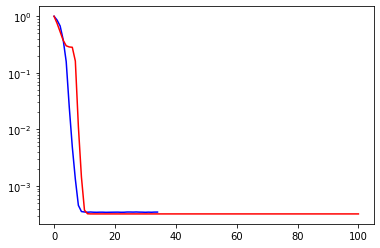

In [45]:
# initialization of a random tensor with noise
A=np.random.normal(0, 1, size=(I, r))
B=np.random.normal(0, 1, size=(J, r))
C=np.random.normal(0, 1, size=(K, r))
noise=np.random.normal(0, 0.001, size=(I,J,K))
tensor=tl.cp_to_tensor((None,[A,B,C]))+noise

# her als
weights1,factors1,it1,error1=CPRAND(tensor,r,int(10*r*np.log(r)+1),it_max=100,err_it_max=20) 
# als
weights2,factors2,it2,error2=als(tensor,r,it_max=100)

# plot
plt.plot(range(len(error1)),error1,'b-')
plt.plot(range(len(error2)),error2,'r-') 
plt.yscale("log")

#### 3 algorithms for 10 random initializations

In [48]:
# plot the median of data fitting/factors error over nb_rand initializations
def comparaison(I,J,K,r,nb_rand,n_samples,exact_err=True,list_factors=False):
  list_err1=[]
  list_err2=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    A=np.random.normal(0, 1, size=(I, r))
    B=np.random.normal(0, 1, size=(J, r))
    C=np.random.normal(0, 1, size=(K, r))
    fac_true=[A,B,C]
    noise=np.random.normal(0, 0.001, size=(I,J,K))
    tensor=tl.cp_to_tensor((None,fac_true))+noise
    norm_tensor=tl.norm(tensor,2)
    if(min_e==None) : min_e=norm_tensor
    if list_factors ==False : 
      #weights1,factors1,it1,error1,cpt=her_CPRAND(tensor,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200) 
      weights1,factors1,it1,error1,cpt=her_Als(tensor,r,it_max=500,err_it_max=100) 
      #weights1,factors1,it1,error1=CPRAND(tensor,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200) 
      weights2,factors2,it2,error2=als(tensor,r,it_max=500) 
      error1=[i * norm_tensor for i in error1]
      error2=[i * norm_tensor for i in error2]
    else : 
      #weights1,factors1,it1,error,cpt,l1=her_CPRAND(tensor,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,list_factors=list_factors) 
      weights1,factors1,it1,error,cpt,l1=her_Als(tensor,r,it_max=500,err_it_max=100,list_factors=list_factors) 
      #weights1,factors1,it1,error,l1=CPRAND(tensor,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200,list_factors=list_factors) 
      weights2,factors2,it2,error,l2=als(tensor,r,it_max=500,list_factors=list_factors) 
      error1=[err_fac(fac_true,i) for i in l1]
      error2=[err_fac(fac_true,i) for i in l2]
    if (min_e>min(min(error1),min(error2))) : min_e=min(min(error1),min(error2))
    list_err1.append(error1)
    list_err2.append(error2)
  n_max1=len(max(list_err1, key=len)) # length of the longest error
  n_max2=len(max(list_err2, key=len))
  mat1=np.array([i + [i[len(i)-1]]*(n_max1-len(i)) for i in list_err1])
  mat2=np.array([i + [i[len(i)-1]]*(n_max2-len(i)) for i in list_err2])
  mat1=mat1-min_e
  mat2=mat2-min_e
  # plot

  plt.plot(range(n_max1),np.median(mat1, axis=0),'b-') 
  plt.plot(range(n_max2),np.median(mat2, axis=0),'r-') 
  plt.yscale("log") 

Attention : modifier la fonction ci-dessus à la main pour faire affichage des différents algo

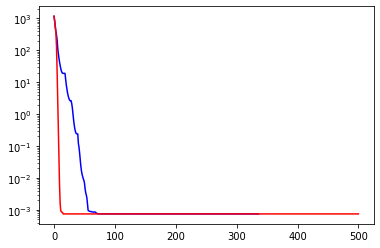

In [49]:
# exact_err=True
comparaison(I,J,K,r,nb_rand,n_samples)
# data-fitting median error : her_Als in blue and als in red

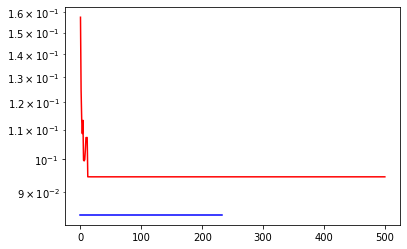

In [155]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True)

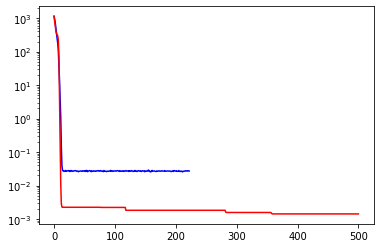

In [158]:
comparaison(I,J,K,r,nb_rand,n_samples)
# data-fitting median error : CPRAND in blue and als in red

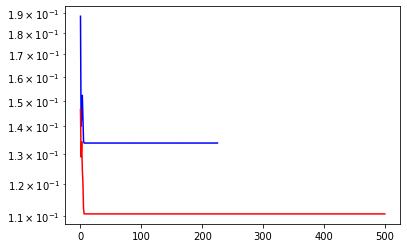

In [159]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True)

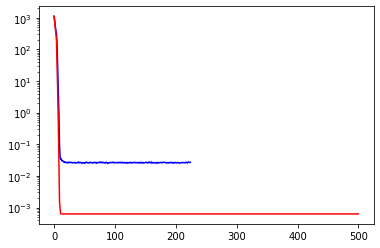

In [161]:
comparaison(I,J,K,r,nb_rand,n_samples)
# data-fitting median error : her_CPRAND in blue and als in red

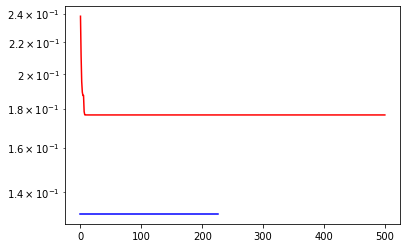

In [162]:
# factors error
comparaison(I,J,K,r,nb_rand,n_samples,list_factors=True)

plot en fonction du temps à faire